### Prove we have hydrate
#### Zach Murphy, 1-25-2022

In [2]:
#imports
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import gas_density as rho_g_fun # Temp IN C and Pressure in PSI
%matplotlib inline

In [3]:
# IMPORT DATA
df=pd.read_excel('ST140_cut_for_saturation.xlsx')
#df2=pd.read_excel('GC_results.xlsx')
df4=pd.read_csv('comp_in_core.csv')
df['P avg']=(df['P up']+df['P down'])/2
df['Gas out']=df['Gas out']*1.1
df['PV in']=df['Gas in']/4.96
df['PV out']=df['Gas out']/4.96

In [4]:
# Density
df['rho_g_m'],df['Z']=rho_g_fun.CH4_EOS(df['T'],df['P down']) #density (mol/m3) and Z
rho_h=912*1000/124+(912*1000/124)*5.75 #density of hydrate (mol/m^3)
rho_l=1027.6*1000/18.02 #(mol/m^3)  #1027.6 #kg/m^3 # !ASSUME TO BE CONSTANT BUT CAN ADD FUCTION TO UPDATE!

In [5]:
# Core Parameters
L=7.62 #sample length (m)
r=0.00493/2 #sample radius (m)
A=m.pi*r**2 #sample area (m^2)
V_sample=A*L #sample volume (m^3)
por=.39 #sample porosity (-)
Vp=V_sample*por #sample pore volume (m^3)
Vp_ml=Vp*10**6
V_line=5 #volume of lines, fittings, etc
R=8.314 #gas constants (Pa m^3)/(mol k)
#BPR=825 #BPR set pressure

In [6]:
# Known Constants
Xwg=0; Xmg=1 #mass fractions in gas phase (gas is pure methane) 
Xmh=0.17; Xwh=0.83  #mol fractions in hydrate phase
Xml=0.0007; Xwl=1-Xml

In [7]:
# Initial Conditions
Sli=0.75 #intial liquid saturation
Sgi=0.0 # initial gas saturation
Shi=0.25 #initial hydrate saturation

In [8]:
#  Initial Moles
mWi=(Xwl*Sli*rho_l+Xwh*Shi*rho_h)*Vp #mols of h2o
mGi=(Xml*Sli*rho_l+Xmg*Sgi*df['rho_g_m'][0]+Xmh*Shi*rho_h)*Vp #mols of ch4

In [9]:
# mol in and mol out each time step
df['mGas in']=(df['Gas in']*0.000001)*df['rho_g_m'] #ml at reservoir conditions to mol gas
df['mGas out']=(df['Gas out']*0.000001)*df['rho_g_m'] #mol gas out

df['mWater in']=df['Water in']*.000001*rho_l*Xwl #mol water in
df['mWater out']=df['Water out']*.000001*rho_l*Xwl #mol water out

df['deltamG']=df['mGas in'].diff()-df['mGas out'].diff() #change in mass of gas in system (kg)
df['deltamW']=df['mWater in'].diff()-df['mWater out'].diff() #change in mass of water in system (kg)

df=df.fillna(0)

df['mGAS']=mGi+df['deltamG'].cumsum() #mol of gas
df['mH2O']=mWi+df['deltamW'].cumsum() #mol of water

In [10]:
# Matrix to solve for Saturation
sat=pd.DataFrame(columns=['time','Sl','Sg','Sh'])
for i,row in df.iterrows():
    A=np.array([[1, 1, 1],
                [Xwl*rho_l, Xwg*df['rho_g_m'][i],Xwh*rho_h],
                [Xml*rho_l, Xmg*df['rho_g_m'][i], Xmh*rho_h]]) 
   
    B=np.array([1,df['mH2O'][i]/Vp,df['mGAS'][i]/Vp])
    X=np.linalg.solve(A,B)
    
    sat=sat.append({'Sh':X[2],'Sg':X[1],'Sl':X[0],'time':df['time'][i]},ignore_index=True)

In [15]:
# MOL of each gas at each time step
df['mCH4 in']=df['mGas in']*0
df['mCH4 out']=(df['mGas out'].diff()*df['%CH4 out']).cumsum()

df['mN2 in']=df['mGas in']*.8
df['mN2 out']=(df['mGas out'].diff()*df['%N2 out']).cumsum()

df['mCO2 in']=df['mGas in']*.2
df['mCO2 out']=(df['mGas out'].diff()*df['%CO2 out']).cumsum()

df['deltamW']=df['mWater in'].diff()-df['mWater out'].diff() #change in mol of water in system
df=df.fillna(0)

df['mCH4']=mGi+df['mCH4 in']-df['mCH4 out']
df['mN2']=df['mN2 in']-df['mN2 out']
df['mCO2']=df['mCO2 in']-df['mCO2 out']

#mol% of each component
df=df.fillna(0)
df['mol_total']=(df['mCH4']+df['mN2']+df['mCO2']+df['mH2O'])

df['mol%CH4']=df['mCH4']/df['mol_total']
df['mol%N2']=df['mN2']/df['mol_total']
df['mol%CO2']=df['mCO2']/df['mol_total']
df['mol%H2O']=df['mH2O']/df['mol_total']

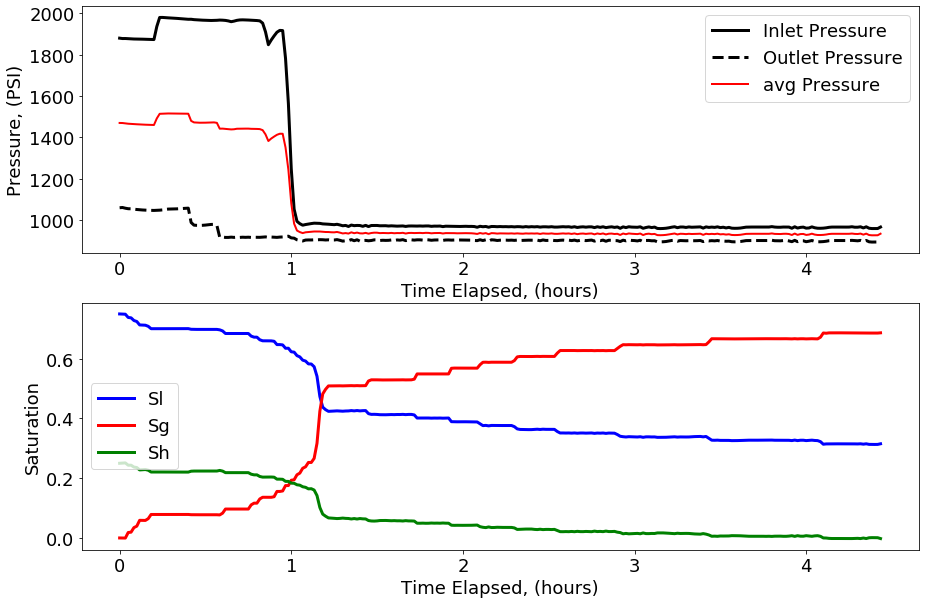

In [17]:
fig=plt.figure(figsize=(15,10))
plt.rcParams['font.size']=18
sharex='True'

plt1=fig.add_subplot(2,1,1)
plt1.plot(df['time'],df['P up'],label='Inlet Pressure',linewidth=3,color='black')
plt1.plot(df['time'],df['P down'],label='Outlet Pressure',linewidth=3,color='black',linestyle='dashed')
plt1.plot(df['time'],df['P avg'],label='avg Pressure',linewidth=2,color='red')
#plt1.axhline(BPR,0,1000,label='BPR Pressure',linewidth=2,color='green')
#plt.xlim([800,1005])
plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([900,1400])
plt.ylabel('Pressure, (PSI)')
plt.legend(loc='best')

plt2=fig.add_subplot(2,1,2,sharex=plt1)
plt2.plot(sat['time'],sat['Sl'],label='Sl',linewidth=3,color='blue')
plt2.plot(sat['time'],sat['Sg'],label='Sg',linewidth=3,color='red')
plt2.plot(sat['time'],sat['Sh'],label='Sh',linewidth=3,color='green')
#plt.ylim([-1,1.5])

plt.xlabel('Time Elapsed, (hours)')

plt.ylabel('Saturation')
plt.legend(loc='best')

Text(0.5, 0.52, 'Vapor')

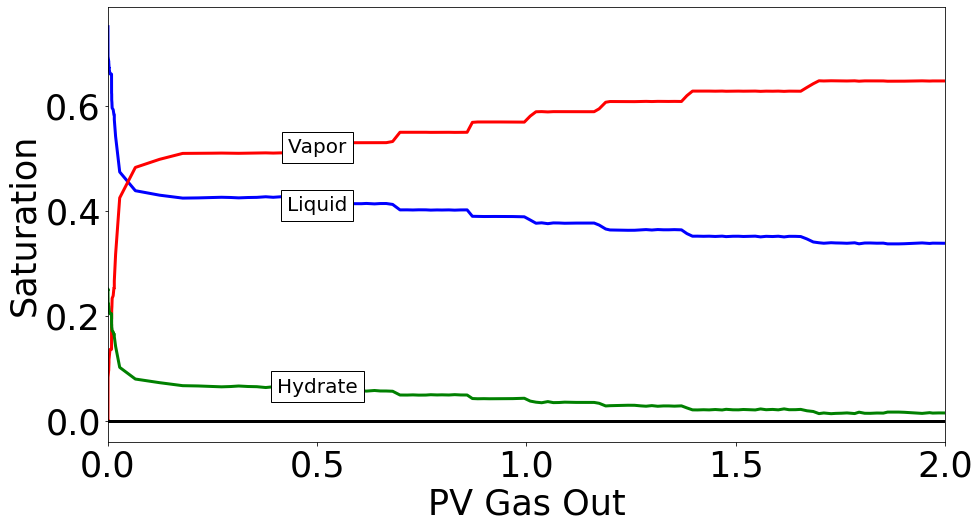

In [19]:
plt.figure(figsize=(15,8))
plt.rcParams['font.size']=35
plt.plot(df['PV out'],sat['Sl'],label='Sl',linewidth=3,color='blue')
plt.plot(df['PV out'],sat['Sg'],label='Sg',linewidth=3,color='red')
plt.plot(df['PV out'],sat['Sh'],label='Sh',linewidth=3,color='green')
plt.axhline(0,0,1000,linewidth=3,color='black')
#plt.ylim([-1,1.5])
plt.xlim([0,2])
plt.xlabel('PV Gas Out')

plt.ylabel('Saturation')

plt.annotate("Hydrate",xy=(.5, 0.065), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.annotate("Liquid",xy=(.5, 0.41), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.annotate("Vapor",xy=(.5, 0.52), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

#plt.legend(loc='best')

In [20]:

df['N2 injected']=0.8
df['CO2 injected']=0.2

CH4i=.6
df['deltaCH4 in']=0
df['deltaCH4 out']=df['%CH4 out']*df['PV out'].diff()
df['CH4 in PV']=df['deltaCH4 in'].cumsum()
df['CH4 out PV']=df['deltaCH4 out'].cumsum()
df['CH4 in core']=CH4i+df['CH4 in PV']-df['CH4 out PV']

df['deltaN2 in']=.8*df['PV in'].diff()
df['deltaN2 out']=df['%N2 out']*df['PV out'].diff()
df['N2 in PV']=df['deltaN2 in'].cumsum()
df['N2 out PV']=df['deltaN2 out'].cumsum()
df['N2 in core']=df['N2 in PV']-df['N2 out PV']

df['deltaCO2 in']=.2*df['PV in'].diff()
df['deltaCO2 out']=df['%CO2 out']*df['PV out'].diff()
df['CO2 in PV']=df['deltaCO2 in'].cumsum()
df['CO2 out PV']=df['deltaCO2 out'].cumsum()
df['CO2 in core']=df['CO2 in PV']-df['CO2 out PV']

C:\Users\zmurp\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\zmurp\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\zmurp\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


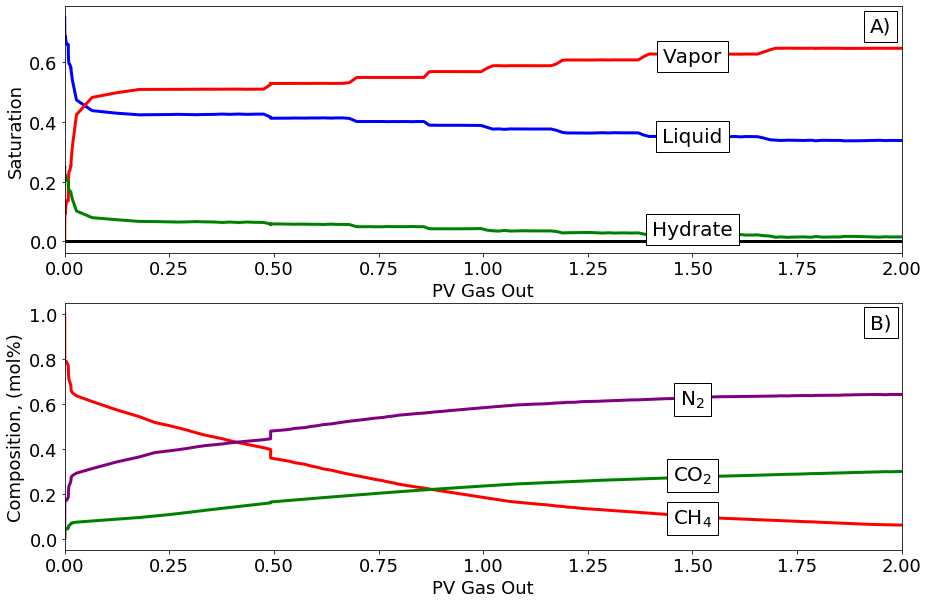

In [22]:
fig=plt.figure(figsize=(15,10))
plt.rcParams['font.size']=18
sharex='True'

plt1=fig.add_subplot(2,1,1)
plt1.plot(df['PV out'],sat['Sl'],label='Sl',linewidth=3,color='blue')
plt1.plot(df['PV out'],sat['Sg'],label='Sg',linewidth=3,color='red')
plt1.plot(df['PV out'],sat['Sh'],label='Sh',linewidth=3,color='green')
plt1.axhline(0,0,1000,linewidth=3,color='black')
#plt.ylim([-1,1.5])
plt.xlim([0,2])
plt.xlabel('PV Gas Out')

plt.ylabel('Saturation')

plt.annotate("Hydrate",xy=(1.5, 0.04), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.annotate("Liquid",xy=(1.5, 0.35), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.annotate("Vapor",xy=(1.5, 0.62), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)
plt.annotate("A)",xy=(1.95, 0.72), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)


plt2=fig.add_subplot(2,1,2,sharex=plt1)
plt2.plot(df['PV out'],df4['CH4_14'],label='CH4 in core',linewidth=3,color='red')
plt2.plot(df['PV out'],df4['N2_14'],label='N2 in core',linewidth=3,color='purple')
plt2.plot(df['PV out'],df4['CO2_14'],label='CO2 in core',linewidth=3,color='green')
#plt.plot(df['PV outh'],df['CO2 in core']/(df['PV in']-df['PV out']),label='CO2/N2',linewidth=3,color='green')
#plt.plot(df['time'],Sli+Shi*Xwh+df['Water in']/Vp_ml-df['Water out']/Vp_ml,label='Water in core',linewidth=3,color='blue')
plt.annotate("CH$_4$",xy=(1.5, 0.09), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.annotate("CO$_2$",xy=(1.5, 0.28), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.annotate("N$_2$",xy=(1.5, 0.62), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.annotate("B)",xy=(1.95, 0.96), xycoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.xlabel('PV Gas Out');
plt.ylabel('Composition, (mol%)');